# Ortholog Finding
#### This module was originally created for cas9 but could extended to any protein.

## Step 1: Profile the Protein
    1. Mean, max, min length of already known orthologs
## Step 2: HMM Seach
    1. Align orthologs
    2. build hmm profile
    3. hmm search against a database
## Step 3: Profile Results
    1. Read hmm results
    2. cluster results by percent identity
    3. remove proteins without required domains


### Env

<p>
conda create --name casenv <br/>
conda install -n casenv libgcc hmmer mafft biopython <br/>
source activate casenv
</p>

In [1]:
%matplotlib inline
import re
from sys import path as spath
spath.append("scripts/")

from Bio.SeqIO import write, parse
from collections import Counter
from CRISPRtools import *
from easyFunctions import *
from HMMParser import *
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from os import chdir, listdir,system
from pandas import Series
from pickle import load #Dump has been wrapped aournd a function from easyFunctions

chdir("data")

### Gene Orthologs Fasta File

In [2]:
gene = "Cas9"
geneProfile = "proteins/DiverseCas9s.faa" #File containing the seed proteins for the hmmsearch
geneFile = "proteins/%s.faa" % gene
alnName  = "alignments/%s.aln" % gene
hmmName  = "hmm/%s.hmm" % gene
hmmResultsDir = "hmm/results"
baseDbsDir = "/mnt/research/germs/shane/databases/assemblies/"
refDatabases = ["NCBI/refseq/bacteria","NCBI/refseq/archaea","NCBI/genbank/bacteria","NCBI/genbank/archaea","PATRIC2/fastas"]

### Profile the gene

In [3]:
dists = []
for rec in parse(geneProfile,"fasta"):dists.append(len(rec.seq))
dists = Series(dists)
minSeqLen = int(dists.min() - (dists.mean() * .25))
maxSeqLen = int(dists.max() + (dists.mean() * .25))
print (dists.describe());
print ("Finding proteins that match the protein profile and are between %i and %i" % (minSeqLen, maxSeqLen))

count      84.000000
mean     1243.547619
std       160.535955
min       984.000000
25%      1099.750000
50%      1207.500000
75%      1376.500000
max      1688.000000
dtype: float64
Finding proteins that match the protein profile and are between 673 and 1998


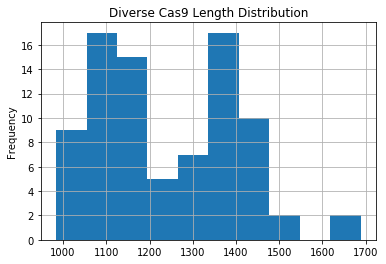

In [4]:
import matplotlib.pyplot as plt
dists.plot(kind='hist',grid=True,title="Diverse Cas9 Length Distribution",figsize=(6,4))
plt.savefig("images/DiverseCas9Lengths.png")
plt.show()

### Make HMM

In [5]:
%%bash -s $geneProfile $alnName $hmmName
mafft --thread 15 --maxiterate 1000 --retree 100 --localpair --reorder --treeout $1 > $2 #Assuming there are <200 sequences in the profile
hmmbuild $3 $2 2>&1 >/dev/null

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.2.1 (June 2018); http://hmmer.org/
# Copyright (C) 2018 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             alignments/Cas9.aln
# output HMM file:                  hmm/Cas9.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     Cas9                    84  4084  1039     7.01  0.590 

# CPU time: 2.13u 0.00s 00:00:02.13 Elapsed: 00:00:02.16


outputhat23=16
treein = 0
compacttree = 0
stacksize: -1 kb
All-to-all alignment.
tbfast-pair (aa) Version 7.407
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
15 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   80 / 84
done.

Progressive alignment ... 
STEP    36 /83 (thread    7) 
Reallocating (by thread 12) ..done. *alloclen = 4507
STEP    55 /83 (thread    6) 
Reallocating (by thread 14) ..done. *alloclen = 5536
STEP    79 /83 (thread   12) 
Reallocating (by thread 2) ..done. *alloclen = 6590
STEP    83 /83 (thread    4) 
done.
tbfast (aa) Version 7.407
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
15 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.

   80 / 84
Segment 

In [3]:
from os import listdir
hmmFiles = listdir(hmmResultsDir)
print("Loaded %i HMM files" % (len(hmmFiles)))
results = set()
for fname in hmmFiles: results.add("%s/%s" % (hmmResultsDir,fname))
hmmFiles = results
assembliesWCrisprs = load(open("pickles/CRISPRs.p","rb")) #From ProcessCRISPRs.ipynb
print("Loaded %i CRISPR files" % (len(assembliesWCrisprs)))
dump(hmmFiles, "pickles/HMMFiles_%s.p" % gene)

Loaded 453958 HMM files
Loaded 453958 CRISPR files

Dumping pickles/HMMFiles_Cas9.p


In [3]:
hmmFiles = load(open("pickles/HMMFiles_%s.p" % gene, "rb"))
print("Loaded %i HMM files" % (len(hmmFiles)))
assembliesWCrisprs = load(open("pickles/CRISPRs.p","rb")) #From ProcessCRISPRs.ipynb
print("Loaded %i CRISPR files" % (len(assembliesWCrisprs)))

Loaded 442759 HMM files
Loaded CRISPR files


### Build hpc scripts for all assemblies with a CRISPR

In [4]:
system("rm ../scripts/hpc/hmmSearch/*")
print("There are %i CRISPR related assemblies" % (len(assembliesWCrisprs)))
fh = open("../scripts/hpc/hmmSearch/HMMSearch_0.sb","w")
header = ""
for line in open("../scripts/hpc/header.sb"): header+=line
fh.write(header)
cmdCount, fileCounter = 0,1
getOrfsCMD = "python /mnt/research/germs/shane/transActRNA/scripts/GetOrfs.py %s sequences/orfs/%s.orfs 673 >/dev/null"
hmmSearchCMD = "hmmsearch hmm/%s.hmm sequences/orfs/%s.orfs >%s/%s.hmmout"

for asmName, operon in assembliesWCrisprs.items():
    asmFilePath = operon.assembly
    if "%s/%s.hmmout" % (hmmResultsDir,asmName) in hmmFiles: continue
    cmdCount += 1
    fh.write("if [ ! -f %s/%s.hmmout ]; then\n" % (hmmResultsDir,asmName)) #Check to see if the hmm profile already exists
    fh.write("\t"+getOrfsCMD % (asmFilePath,asmName) + "\n")
    fh.write("\t"+hmmSearchCMD % (gene,asmName,hmmResultsDir,asmName)+"\n")
    fh.write("\thmmsize=$(wc -l <\"%s/%s.hmmout\") \n" % (hmmResultsDir,asmName))
    fh.write("\tif [ $hmmsize -le 40 ]; then \n")
    fh.write("\t\trm sequences/orfs/%s.orfs \n" % (asmName))
    fh.write("\tfi\n")
    fh.write("fi\n\n")
    if cmdCount % 50 == 0:
        fh.close()
        fh = open("../scripts/hpc/hmmSearch/HMMSearch_%i.sb" % (fileCounter),"w")
        fh.write(header)
        fileCounter += 1
fh.close()
print("There are %i files for %i assemblies" % (fileCounter,cmdCount))

There are 453958 CRISPR related assemblies
There are 61 files for 6005 assemblies


### Do HMM search on each assembly

In [ ]:
%%bash 
bash ../scripts/hpc/LaunchHMMSearch.sh

### Read the HMM Results and create fasta files

In [7]:
%%bash 
sbatch ../scripts/hpc/ReadHMM_Results.sb # This script does the same thing as the cell below
#cat ../scripts/hpc/ReadHMM_Results.sb

Submitted batch job 24156860


In [ ]:
from CRISPRtools import CasOperons
crisprFiles = load(open("pickles/CRISPRs.p","rb")) 
casOperons = CasOperons(gene)
casOperons.hasCas9(hmmResultsDir+"/",crisprFiles)
dump(casOperons, "pickles/%s_Operons.p" % gene)

# Sort through all the results and make a file with all of the Cas proteins of interest. 
# If there are duplicates only keep the duplicates that come from a unique chromosome
casOperons = load(open("pickles/%s_Operons.p" % gene,"rb"))
allCasAsmFile = "assemblies/All_%s_Representative_Assemblies.fasta" % (gene)
allCasAAsFile = "proteins/All_%s-Like.faa" % (gene)
casOperons.uniqueNukeSeqs(allCasAsmFile,allCasAAsFile,gene)
dump(casOperons, "pickles/casOperonDataStructureW%s.p" % gene) 
system("sbatch ../scripts/hpc/DomainSearch.sb")

## Profile domains of the Cas protein of interest

Total number of unique proteins: 5269


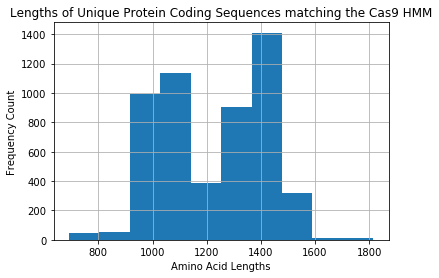

In [11]:
dist,prots = [],set()
protSeqs = dict(fasta_index("proteins/All_Cas9-Like-filtered.faa",'fasta')) #All_%s-Like.faa" % gene))
seqCounter = {}
for rec in parse("proteins/All_Cas9-Like-filtered.faa","fasta"): 
    seq = str(rec.seq).strip().upper()
#     if len(seq)>2000:continue
    if seq not in prots:
        prots.add(seq)
        dist.append(len(seq))
        seqCounter[seq] = [rec.id]
    else:
        seqCounter[seq].append(rec.id)
dist = Series(dist)
plt.title("Lengths of Unique Protein Coding Sequences matching the %s HMM" % gene)
plt.xlabel("Amino Acid Lengths")
plt.ylabel("Frequency Count")
hist = dist.hist(grid=True,figsize=(6,4))
print ("Total number of unique proteins:", len(dist))
plt.savefig("images/Unique%sLengths.png" %(gene))
plt.show()

In [4]:
%%bash
cat ../scripts/hpc/DomainSearch.sb

#!/bin/bash --login
########## Define Resources Needed with SBATCH Lines ##########
 
#SBATCH --time=6:00:00             # limit of wall clock time - how long the job will run (same as -t)
#SBATCH --ntasks=1                  # number of tasks - how many tasks (nodes) that you require (same as -n)
#SBATCH --cpus-per-task=20           # number of CPUs (or cores) per task (same as -c)
#SBATCH --mem=20G                    # memory required per node - amount of memory (in bytes)
#SBATCH --job-name DomainSearch      # you can give your job a name for easier identification (same as -J)
#SBATCH --account shadeash-colej 
#SBATCH --mail-type=END                      # Mail type:
#SBATCH --mail-user=dooley.shanek@gmail.com  # Mail user:


MY_PATH=/mnt/research/germs/shane/transActRNA/data
cd $MY_PATH

hmmsearch --max --cpu 20 --pfamtblout $MY_PATH/hmm/Cas9-Like_phi.pfamtbl --tblout $MY_PATH/hmm/Cas9-Like_phi.tbl --domtblout $MY_PATH/hmm/Cas9-Like_phi.faa.domtbl $MY_PATH/hmm/phi_domains.hmm $MY_PA

### Profile the domains

In [ ]:
%%bash
sbatch ../scripts/hpc/DomainSearch.sb

## Read the results

In [5]:
spacePat = re.compile( r'^[\t ]*$')
hits=SamplesDict()
print("Reading Table Definitions")
for line in open("hmm/Cas9-Like_phi.faa.domtbl"):
    if line.startswith( '#' ):continue
    fields = re.split( r'(\[[^\[]*[^\S]+[^\]]*\]|[^\t ]+)', line.strip() )
    fields = DomainHit(list(filter(lambda i: not spacePat.search(i), fields)))
    hits[fields.hit]=fields
print(len(hits.samples))
dump(hits,"pickles/%s_HMM_DOMAIN_Search_Results.p" % (gene))

Reading Table Definitions
28671

Dumping pickles/Cas9_HMM_DOMAIN_Search_Results.p


# Newest Run

In [12]:
hits = load(open("pickles/%s_HMM_DOMAIN_Search_Results.p" % (gene),"rb"))
hasAllDomains = hits["RuvC_1_Cas9"].intersection(hits["RuvC_2_Cas9"].intersection(hits["RuvC_3_Cas9"].intersection(hits["HNH_Cas"])))
allSamples = set(hits.samples.keys())
nSamples = len(allSamples)
noRuvC1 = allSamples.difference(hits["RuvC_1_Cas9"])
noRuvC2 = allSamples.difference(hits["RuvC_2_Cas9"])
noRuvC3 = allSamples.difference(hits["RuvC_3_Cas9"])
noHNH   = allSamples.difference(hits["HNH_Cas"])

htmlString ="""<table align='left'>
    """\
    "<tr style='background-color:#9B7E46;color:white'><td>Number of Proteins:</td><td>%i</td></tr>" % (nSamples) +\
    "<tr style='background-color:#373D20;color:white'><td>Has all domains</td><td>%i</td></tr>" % (len(hasAllDomains)) +\
    "<tr style='background-color:#BCBD8B;color:white'><td>Number of sequences with no detected RuvCI domain</td><td>%i</td></tr>" % (len(noRuvC1)) +\
    "<tr style='background-color:#717744;color:white'><td>Number of sequences with no detected RuvCII domain</td><td>%i</td></tr>" % (len(noRuvC2)) +\
    "<tr style='background-color:#766153;color:white'><td>Number of sequences with no detected RuvCIII domain</td><td>%i</td></tr>" % (len(noRuvC3)) +\
    "<tr style='background-color:#F4B266;color:white'><td>Number of sequences with no detected HnH</td><td>%i</td></tr>" % (len(noHNH)) +\
    """
    </table>
"""
display(HTML(htmlString))
#    "<tr style='background-color:#766153;color:white'><td>Number of proteins with neither an RuvCI nor a RuvCIII</td><td>%i</td></tr>" % (len(neitherDomain)) +\
print(htmlString)

Number of Proteins:,28671
Has all domains,27026
Number of sequences with no detected RuvCI domain,921
Number of sequences with no detected RuvCII domain,971
Number of sequences with no detected RuvCIII domain,432
Number of sequences with no detected HnH,186


<table align='left'>
    <tr style='background-color:#9B7E46;color:white'><td>Number of Proteins:</td><td>28671</td></tr><tr style='background-color:#373D20;color:white'><td>Has all domains</td><td>27026</td></tr><tr style='background-color:#BCBD8B;color:white'><td>Number of sequences with no detected RuvCI domain</td><td>921</td></tr><tr style='background-color:#717744;color:white'><td>Number of sequences with no detected RuvCII domain</td><td>971</td></tr><tr style='background-color:#766153;color:white'><td>Number of sequences with no detected RuvCIII domain</td><td>432</td></tr><tr style='background-color:#F4B266;color:white'><td>Number of sequences with no detected HnH</td><td>186</td></tr>
    </table>



# Old Run

In [4]:
#hits = load(open("pickles/%s_HMM_DOMAIN_Search_Results.p" % (gene),"rb"))
hasAllDomains = hits["RuvC_1_Cas9"].intersection(hits["RuvC_2_Cas9"].intersection(hits["RuvC_3_Cas9"].intersection(hits["HNH_Cas"])))
allSamples = set(hits.samples.keys())
nSamples = len(allSamples)
noRuvC1 = allSamples.difference(hits["RuvC_1_Cas9"])
noRuvC2 = allSamples.difference(hits["RuvC_2_Cas9"])
noRuvC3 = allSamples.difference(hits["RuvC_3_Cas9"])
noHNH   = allSamples.difference(hits["HNH_Cas"])

htmlString ="""<table align='left'>
    """\
    "<tr style='background-color:#9B7E46;color:white'><td>Number of Proteins:</td><td>%i</td></tr>" % (nSamples) +\
    "<tr style='background-color:#373D20;color:white'><td>Has all domains</td><td>%i</td></tr>" % (len(hasAllDomains)) +\
    "<tr style='background-color:#BCBD8B;color:white'><td>Number of sequences with no detected RuvCI domain</td><td>%i</td></tr>" % (len(noRuvC1)) +\
    "<tr style='background-color:#717744;color:white'><td>Number of sequences with no detected RuvCII domain</td><td>%i</td></tr>" % (len(noRuvC2)) +\
    "<tr style='background-color:#766153;color:white'><td>Number of sequences with no detected RuvCIII domain</td><td>%i</td></tr>" % (len(noRuvC3)) +\
    "<tr style='background-color:#F4B266;color:white'><td>Number of sequences with no detected HnH</td><td>%i</td></tr>" % (len(noHNH)) +\
    """
    </table>
"""
display(HTML(htmlString))
#    "<tr style='background-color:#766153;color:white'><td>Number of proteins with neither an RuvCI nor a RuvCIII</td><td>%i</td></tr>" % (len(neitherDomain)) +\
print(htmlString)

Number of Proteins:,30782
Has all domains,29050
Number of sequences with no detected RuvCI domain,964
Number of sequences with no detected RuvCII domain,1014
Number of sequences with no detected RuvCIII domain,450
Number of sequences with no detected HnH,181


<table align='left'>
    <tr style='background-color:#9B7E46;color:white'><td>Number of Proteins:</td><td>30782</td></tr><tr style='background-color:#373D20;color:white'><td>Has all domains</td><td>29050</td></tr><tr style='background-color:#BCBD8B;color:white'><td>Number of sequences with no detected RuvCI domain</td><td>964</td></tr><tr style='background-color:#717744;color:white'><td>Number of sequences with no detected RuvCII domain</td><td>1014</td></tr><tr style='background-color:#766153;color:white'><td>Number of sequences with no detected RuvCIII domain</td><td>450</td></tr><tr style='background-color:#F4B266;color:white'><td>Number of sequences with no detected HnH</td><td>181</td></tr>
    </table>



#### Profile the lengths of where the domains are located in the protein


Mean distance from RuvC_1 to start of protein: 11 std: 9


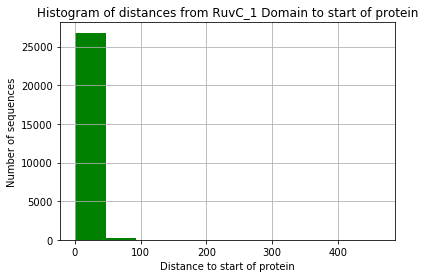

In [13]:
from pandas import Series
ruvC1Coords = []
ruvC3Coords = []
samples = []
difs = []
for sample in hasAllDomains:
    ruc1Start = hits.samples[sample]["RuvC_1_Cas9"].start
    ruc3End = hits.samples[sample]["RuvC_3_Cas9"].dend
    ruvC1Coords.append(ruc1Start)
    ruvC3Coords.append(ruc3End)
    difs.append(ruc3End-ruc1Start)
    samples.append(sample)
    
ruvC1Dists = Series(ruvC1Coords,index=samples)
ruvC3Dists = Series(ruvC3Coords,index=samples)
distBetween = Series(difs,index=samples)

print ("\nMean distance from RuvC_1 to start of protein: %.0f std: %.0f" % (ruvC1Dists.mean(), ruvC1Dists.std()))

# the histogram of the data
n, bins, patches = plt.hist(ruvC1Dists,facecolor='green')
plt.xlabel('Distance to start of protein')
plt.ylabel('Number of sequences')
plt.title("Histogram of distances from RuvC_1 Domain to start of protein")
plt.grid(True)
plt.show()


Mean distance from RuvC_3 to end of protein: 256 std: 57


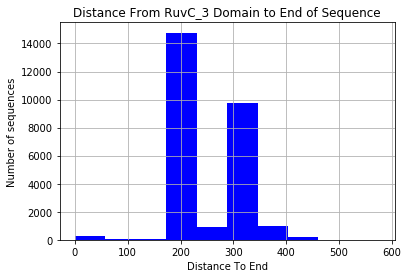

In [8]:
print ("\nMean distance from RuvC_3 to end of protein: %.0f std: %.0f" % (ruvC3Dists.mean(), ruvC3Dists.std()))

# the histogram of the data
n, bins, patches = plt.hist(ruvC3Dists,facecolor='blue')
plt.xlabel('Distance To End')
plt.ylabel('Number of sequences')
plt.title("Distance From RuvC_3 Domain to End of Sequence")
plt.grid(True)
plt.savefig("images/%s_RuvC3_DomainLengths.png" % gene)
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
ax1.hist(ruvC1Coords,facecolor='green')
ax1.grid(True)
ax2.hist(ruvC3Coords,facecolor='blue') 
plt.grid(True)
plt.show();

In [9]:
import numpy as np
start_outliers = set(ruvC1Dists[ruvC1Dists > ruvC1Dists.mean()+8*ruvC1Dists.std()].index) #RuvC1 outlier
end_outliers = set(ruvC3Dists[ruvC3Dists > ruvC3Dists.mean()+5*ruvC3Dists.std()].index) #RuvC3 outlier
hasGoodDomains = hasAllDomains.difference(start_outliers.union(end_outliers))
htmlString ="""<table align='left'>
    """\
    "<tr style='background-color:#373D20;color:white'><td>No outlier domains</td><td>%i</td></tr>" % (len(hasGoodDomains)) +\
    "<tr style='background-color:#BCBD8B;color:white'><td>Number of RuvC1 outliers</td><td>%i</td></tr>" % (len(start_outliers)) +\
    "<tr style='background-color:#717744;color:white'><td>Number of RuvC3 outliers</td><td>%i</td></tr>" % (len(end_outliers)) +\
    "<tr style='background-color:#766153;color:white'><td>Outlier Intersection</td><td>%i</td></tr>" % (len(start_outliers.intersection(end_outliers))) +\
    """
    </table>
"""

#"<tr style='background-color:#766153;color:white'><td>Outlier Intersection</td><td>%i</td></tr>" % (len(start_outliers.intersection(end_outliers))) +\
# htmlString += "<br/><img src='nwks/%s.png' style='width:1000px;height:1000px;'>" % ("Cas9-Subtree1.V2")
display(HTML(htmlString))  
print(htmlString)
dump(hasGoodDomains,"pickles/%s_CorrectDomains.p" % gene)

No outlier domains,27001
Number of RuvC1 outliers,24
Number of RuvC3 outliers,1
Outlier Intersection,0


<table align='left'>
    <tr style='background-color:#373D20;color:white'><td>No outlier domains</td><td>27001</td></tr><tr style='background-color:#BCBD8B;color:white'><td>Number of RuvC1 outliers</td><td>24</td></tr><tr style='background-color:#717744;color:white'><td>Number of RuvC3 outliers</td><td>1</td></tr><tr style='background-color:#766153;color:white'><td>Outlier Intersection</td><td>0</td></tr>
    </table>


Dumping pickles/Cas9_CorrectDomains.p


## Remove chrs that have more than 1 Cas9

In [10]:
#Checked domains, removed outliers, now remove chrs that have more than 1 Cas9
hasGoodDomains = load(open("pickles/%s_CorrectDomains.p" % gene,"rb"))
corrected = {}
remove,baseMap = set(),{}
print(len(hasGoodDomains))
for orfName in hasGoodDomains:
    baseCHR = orfName[:orfName.rfind("_")]
    if baseCHR in corrected:
        try: 
            baseMap[baseCHR].add(orfName)
            baseMap[baseCHR].add(corrected[baseCHR])
        except: baseMap[baseCHR] =set([corrected[baseCHR],orfName])
        remove.add(orfName)
        remove.add(corrected[baseCHR])
    corrected[baseCHR] = orfName

hasGoodDomains = hasGoodDomains.difference(remove)
print(len(hasGoodDomains))

27001
26857


#### Cluster the sequences to choose a representative sequence

In [13]:
%%bash -s $gene
cd-hit -i proteins/All_$1-Like-filtered.faa -M 0 -d 0 -c .90 -sc 1 -o proteins/$1-Like-clustered.faa >logs/$1_ClusterLog.log
tail -n 8 logs/$1_ClusterLog.log > logs/clusterInfo
head -n 1 logs/clusterInfo; rm logs/clusterInfo
mv proteins/$1-Like-clustered.faa.clstr clusters/

    26857  finished       2147  clusters


In [12]:
casOperons = load(open("pickles/%s_Operons.p" % gene,"rb"))
casOperons.getRepSeqs(hasGoodDomains,"proteins/All_%s-Like-filtered.faa" %(gene),"proteins/All_%s-Like.faa" % (gene)) #TODO add clean to remove non good domains
dump(casOperons, "pickles/%s_Operons.p" % gene)

Saved 26857 sequences to proteins/All_Cas9-Like-filtered.faa

Dumping pickles/Cas9_Operons.p


## Create the file with just the chromosomes related to the representative proteins

In [6]:
def getRepSeqs(hasGoodDomains,repSeqsFile,allCasRepsFile):
    repSeqs = open(repSeqsFile,'w')
    counter = 0
    for rec in parse(allCasRepsFile,"fasta"):
        if rec.id in hasGoodDomains: 
            counter +=1
            write(rec,repSeqs,"fasta")
    repSeqs.close()
    print("Saved %i sequences to %s" % (len(hasGoodDomains),repSeqsFile))
    print(counter)

In [7]:
casRelatedProteins = dict(fasta_index("proteins/%s-Like-clustered.faa"%gene,'fasta'))
getRepSeqs(casRelatedProteins.keys(),"assemblies/%s_Representative_Assemblies.fasta" % gene, "assemblies/All_Cas9_Representative_Assemblies_copy.fasta")


Saved 2147 sequences to assemblies/Cas9_Representative_Assemblies.fasta
2147


### Align the sequences and create a phylogenetic tree

In [14]:
%%bash -s $gene
sbatch ../scripts/hpc/Alignment.sb
tail -n 3 ../scripts/hpc/Alignment.sb

Submitted batch job 24126726
srun -A shadeash-colej mafft --nomemsave --thread 20 --maxiterate 1000 --reorder --treeout proteins/Cas9-Like-clustered.faa > alignments/Cas9-Like-clustered.aln
 
scontrol show job $SLURM_JOB_ID


In [26]:
from types import MethodType
repFile = "assemblies/%s_Representative_Assemblies.fasta" % (gene) #File already exists
allRepAssemblies = "assemblies/All_%s_Representative_Assemblies.fasta" % (gene) #The new file we are creating
print("Reading rep seqs")
# allNukSeqs = fasta_index(allRepAssemblies, "fasta")
print("Making reps")
repSeqs = open(repFile,"w")
casRelatedProteins = fasta_index("proteins/%s-Like-clustered.faa" % gene, "fasta")
for protID,rec in casRelatedProteins.items():
    baseID = protID[:protID.rfind("_")]
    nuceRec = allNukSeqs[baseID]
    nuceRec.id = protID
    if not path.exists("assemblies/pseudoChromos/%s.fasta" % (protID)):
        with open("assemblies/pseudoChromos/%s.fasta" % (protID),'w') as fh: write(nuceRec,fh,"fasta")
    write(nuceRec,repSeqs,"fasta")
    locus = casOperons[protID]
    setattr(locus,'seq',nuceRec) #TODO comment this out on re-run
    locus.seq = nuceRec
repSeqs.close()
dump(casOperons,"pickles/%s_Operons.p" % gene)    
# corrected = set()
# for id in seqs: corrected.add(id[:id.rfind("_")])
# casOperons.getRepSeqs(corrected,repFile,allRepAssemblies)

Reading rep seqs
Making reps

Dumping pickles/Cas9_Operons.p


In [25]:
allNukSeqs = {}
badIDs = {}
for rec in parse(allRepAssemblies,"fasta"):
    if rec.id in allNukSeqs:
        badIDs[rec.id] = (allNukSeqs[rec.id].seq.upper() == rec.seq.upper())
        continue
    allNukSeqs[rec.id] = rec
print(len(badIDs)) 
# sum(badIDs.values())
badIDs

137


In [29]:
allClusters, allClusterSeqIDs = {},{}
clusterPercs = {}
for line in open("clusters/%s-Like-clustered.faa.clstr" % (gene)):
    line = line.strip()
    if ">Cluster" in line: clusterID = line.replace(">","")
    else:
        sequenceID = line[line.find(">")+1:line.find(".")] 
        seqID = line[line.find(">")+1:line.find("...")] 
        perc = line.split(" ")[-1]
        aa_s = line.split("\t")[1]
        aa_s = int(aa_s.split("aa,")[0])
        if "%" in perc: clusterPercs[seqID] = (aa_s,float(perc.replace("%","")))
        try:allClusters[clusterID].add(seqID)
        except:allClusters[clusterID]=set([seqID])
        try:allClusterSeqIDs[seqID].add(clusterID)
        except:allClusterSeqIDs[seqID]=set([clusterID])
allClusters, allClusterSeqIDs
dump(allClusters,"pickles/%s_ClusteringResults.p" % (gene))
dump(allClusterSeqIDs,"pickles/%s_RevClusteringResults.p" % (gene))
dump(clusterPercs,"pickles/%s_ClusterPercs.p" % (gene))


Dumping pickles/Cas9_ClusteringResults.p

Dumping pickles/Cas9_RevClusteringResults.p

Dumping pickles/Cas9_ClusterPercs.p


# Build the Cas9 Finding Report

In [30]:
from Rho import *
metadata = {}
for line in open("tables/AllCas9Meta.txt"):
    seqID,description = line.strip().split("\t")
    metadata[seqID]=description

casOperons = load(open("pickles/%s_Operons.p" % gene,"rb"))
clusters = processClusterFile("clusters/%s-Like-clustered.faa.clstr" % (gene))
#seqCounter[seq], ruvC1Dists,ruvC3Dists, distBetween
allAssemblies = load(open("pickles/All_%s_Representative_Assemblies.p" % (gene),'rb'))
allProts = dict(fasta_index("proteins/All_Cas9-Like.faa",'fasta'))

In [42]:
report = open("tables/Cas9FindingReport.tsv",'w')

columns = ['Protein ID',"Prot Length","Chr Length","Cluster","Cluster Members",'Systems with idenditcal protein',
           "RuvC I to Start","RuvC III to End","AAs Between I-III","#CRISPR Arrays","Consensus Repeats Sequence(s)",
           "Consensus Length","#Repeats in CRISPR Search","#BLAST Repeats","Metadata"]

report.write("\t".join(columns)+'\n')
skips = 0
for protID in allAssemblies:
    try:
        operon = casOperons.operons[casOperons.seqMap[protID]]
        crispr = operon.getCRISPR(protID)
    
        values = {
            "Protein ID": protID,
            "Prot Length": len(allProts[protID]),
            "Chr Length": len(operon.seq.seq),
            "Cluster": clusters.revMap[protID],
            "Cluster Members": len(clusters[clusters.revMap[protID]].members),
            "Systems with idenditcal protein": len(seqCounter[str(allProts[protID].seq).strip().upper()]),
            "RuvC I to Start":ruvC1Dists[protID],
            "RuvC III to End":ruvC3Dists[protID],
            "AAs Between I-III":distBetween[protID],
            "#CRISPR Arrays": len(crispr.consensusRepeats),
            "Consensus Repeats Sequence(s)": ",".join(crispr.consensusRepeats),
            "Consensus Length": len(list(crispr.consensusRepeats)[0]),
            "#Repeats in CRISPR Search":len(crispr.spacers),
            "#BLAST Repeats":len([]), # will be crispr.numBlastRes
            "Metadata":metadata[protID]
        }
    except: 
        skips+=1
        continue
    
    for col in columns: report.write(str(values[col])+"\t")
    report.write('\n')
    
print(skips,len(allAssemblies))
report.close()

5693 28855


In [ ]:
print("Yay Done!!!!!")

In [8]:
from Bio.SeqIO import index
gene='Cas9'
casRelatedProteins = index("proteins/%s-Like-clustered.faa" % (gene),"fasta")
fh = open("proteins/%s-Like-clustered_copy.faa" % (gene),'w')
for rec in casRelatedProteins.values():
    rec.description = ''
    write(rec,fh,'fasta')
fh.close()

In [9]:
%%bash
mv proteins/Cas9-Like-clustered_copy.faa proteins/Cas9-Like-clustered.faa #To clean up the descriptions

In [ ]:
goodDomIDS = set()
goodDomMap = {}
hasGoodDomains = load(open("pickles/%s_CorrectDomains.p" % gene, "rb"))
for prot in hasGoodDomains: 
    baseID = prot[:prot.rfind("_")] # remove the orf identifier
    goodDomIDS.add(baseID)
    try: goodDomMap[baseID].add(prot)
    except: goodDomMap[baseID] = set([prot])
print("Found %i Cas9-like proteins on the same sequence" % (len(hasGoodDomains) - len(goodDomIDS)))
print("Total proteins found %i in (%i == %i) sequences" % (len(hasGoodDomains),len(goodDomMap),len(goodDomIDS)))
dump(goodDomIDS,"pickles/%s_GoodDomainIDS.p" %(gene))
dump(goodDomMap,"pickles/%s_GoodDomMap.p" %(gene))

# Now we have assemblies with a crispr and a Cas9. Next we will copy all of the unique seqeuences over to the same place. This will allow the systems with the same protein but different DNA sequences to exist.

In [ ]:
assemblyDir = "assemblies/assemblies_W_%s/" % (gene)
cas9Assemblies = listdir(assemblyDir)
goodDomIDS = load(open("pickles/%s_GoodDomainIDS.p" % (gene), "rb"))
goodDomMap = load(open("pickles/%s_GoodDomMap.p"    % (gene), "rb"))
hmm_parser = load(open("pickles/%s_HMM_Parsing_Results.p" % (gene), "rb"))

In [ ]:
assembliesWCrisprs = load(open("pickles/allAssemblyW_CRISPRs.p","rb"))

In [ ]:
def getDB(aPath): 
    if "genbank" in aPath: return "genbank"
    if "refseq"  in aPath: return "refseq"
    return "pat2"
hmm_parser = load(open("pickles/%s_HMM_Parsing_Results.p" % (gene), "rb"))
len(hmm_parser)

In [ ]:
# Copy unique nucleotide sequence
from Bio.SeqIO import index, write
from os import system
# hmm_parser = load(open("pickles/%s_HMM_Parsing_Results.p" % (gene), "rb"))
hasGoodDomains = load(open("pickles/%s_CorrectDomains.p" % gene, "rb"))
# assembliesWCrisprs = load(open("pickles/allAssemblyW_CRISPRs.p","rb"))

nukSeqHash, protAssemblyMap, assemblyProtMap = {}, {}, {}
# BASEFILENAME eg GCF_0001232342.5.fasta = GCF_0001232342.5
# protAssemblyMap = {CHROM_ORF#:BASEFILENAME}

counter = 0
#casFiltered = open("proteins/All_%s-Like-filtered.faa" % gene, "w")
crPath = "/mnt/research/germs/shane/databases/crisprs/pilerCR"
for baseID, proteins in hmm_parser:
    assemblyProtMap[baseID] = {}
    protIDs = proteins.proteins.keys()
    keepers = hasGoodDomains.intersection(protIDs)
    if len(keepers) > 0:
#         seqs = index(assembliesWCrisprs[baseID], "fasta")
#         db = getDB(assembliesWCrisprs[baseID])
        for protID in keepers:
            counter += 1
            protAssemblyMap[protID] = baseID
            baseProtID = protID[:protID.rfind("_")]
            try: assemblyProtMap[baseID][baseProtID].add(protID)
            except: assemblyProtMap[baseID] = {baseProtID:set([protID])}
#             pchr = seqs[baseProtID]
#             nukeSeq = str(pchr.seq).upper()
#             if nukeSeq not in nukSeqHash:
#                 if not path.exists("crisprs/%s.pcrout" % (protID)):
#                     system("ln -s %s/%s/%s.pcrout crisprs/%s.pcrout" % (crPath,db,baseID,protID))
#                     with open("assemblies/pseudoChromos/%s.fasta" % protID, "w") as seqFH:
#                         pchr.id = protID
#                         write(pchr, seqFH, "fasta")
#                 write(proteins.proteins[protID],casFiltered,"fasta")
#                 nukSeqHash[nukeSeq] = set([protID])
#             else: nukSeqHash[nukeSeq].add(protID)
            if counter % 1000 == 0: print(counter/1000,end=' ')
# casFiltered.close()
# dump(nukSeqHash,"pickles/%s_nukSeqHash.p" % gene)
# dump(protAssemblyMap,"pickles/%s_protAssemblyMap.p" % gene)
dump(assemblyProtMap,"pickles/%s_assemblyProMap.p" % gene)

#### Write all proteins to a file ->Cluster proteins -> Align the representatives

In [ ]:
gene = "Cas9"
clusterID = ""
allClusters, allClusterSeqIDs = {},{}
clusterPercs = {}
for line in open("clusters/%s-Like-clustered.faa.clstr" % (gene)):
    line = line.strip()
    if ">Cluster" in line: clusterID = line.replace(">","")
    else:
        seqID = line[line.find(">")+1:line.find("...")] 
        perc = line.split(" ")[-1]
        aa_s = line.split("\t")[1]
        aa_s = int(aa_s.split("aa,")[0])
        if "%" in perc: clusterPercs[seqID] = (aa_s,float(perc.replace("%","")))
        try:allClusters[clusterID].add(seqID)
        except:allClusters[clusterID]=set([seqID])
        try:allClusterSeqIDs[seqID].add(clusterID)
        except:allClusterSeqIDs[seqID]=set([clusterID])
allClusters, allClusterSeqIDs
dump(allClusters,"pickles/%s_ClusteringResults.p" % (gene))
dump(allClusterSeqIDs,"pickles/%s_RevClusteringResults.p" % (gene))
dump(clusterPercs,"pickles/%s_ClusterPercs.p" % (gene))

In [ ]:
from Bio.SeqIO import index,write
from os import listdir
gene = "Cas9"
casAssemblies = index("data/proteins/%s-Like-clustered.faa" % (gene), "fasta")
casFH = open("data/assemblies/%s_Representative_Assemblies.fasta" % (gene), "w")
counter = 0
for fname in listdir("data/assemblies/pseudoChromos/"):
    seqID = fname[:fname.find(".fasta")]
    if seqID in casAssemblies: 
        asm = index("data/assemblies/pseudoChromos/"+fname, "fasta")
        write(asm[seqID],casFH,"fasta")
        if counter % 100 == 0 : print(counter/100,end=" ")
        counter +=1
casFH.close()
counter 

In [ ]:
dump(nukSeqHash,"pickles/%s_nukSeqHash.p" % gene)
dump(protAssemblyMap,"pickles/%s_protAssemblyMap.p" % gene)

In [ ]:
hmm_parser = HMM_Parser()
hmmFiles = os.listdir(hmmResultsDir)
counter, numWithCas9Like = 0, 0
print ("Working on the %s directory which contains %i files" % (hmmResultsDir,len(hmmFiles)))
for fileName in hmmFiles:
    if ".hmmout" not in fileName: continue
    fileStats = os.stat(os.path.join(hmmResultsDir,fileName)).st_size  
    counter+=1
    if counter % 100000 == 0: print(counter,numWithCas9Like)
    if fileStats < 1900: continue #Less than 1900 means no results were found
    hmm_parser.parse(os.path.join(hmmResultsDir,fileName))
    numWithCas9Like +=1
dump(hmm_parser,"pickles/%s_HMM_Parsing_Results.p" % (gene))

In [ ]:
protCounter, fileCounter = 0,1
protSeqs = set()
IDs, dupes = {},{}
casAll = open("proteins/All_%s-Like.faa" % gene,"w")
casUnique = open("proteins/Unique_%ss.faa" % gene,"w")
# fh = open("../scripts/hpc/hmmSearch/HMMSearch_0.sb","w")
# header = ""
# for line in open("../scripts/hpc/header.sb"): header+=line
# fh.write(header)

for baseID,proteins in hmm_parser:
    for protID, rec in proteins:
        if len(rec.seq) > 2100: continue
        if rec.id in IDs: 
            try: dupes[rec.id].add(baseID)
            except: 
                dupes[rec.id] = set([baseID])
                dupes[rec.id].add(IDs[rec.id])
            continue
        IDs[rec.id]=baseID
        seq = str(rec.seq).upper()
        protCounter +=1
        if seq not in protSeqs:
            
            protSeqs.add(seq)
            write(rec,casUnique,"fasta")
        write(rec,casAll,"fasta")
casUnique.close() 
casAll.close()
print("Number of dupes: ",len(dupes))
print ("Writing %i proteins from %i assemblies to file: proteins/All_%s-Like.faa" % (protCounter,numWithCas9Like,gene))
print("Of the %s proteins, there are %i unique proteins" % (protCounter,len(protSeqs)))

In [ ]:
from Bio.SeqIO import index, write
seqs = index("proteins/All_%s-Like.faa" % (gene),"fasta")
fh = open("proteins/multiple%ss.faa" % (gene),"w")
for baseID, orfList in baseMap.items():
    orf1, orf2 = list(orfList)
    seq1 = str(seqs[orf1].seq).upper()
    seq2 = str(seqs[orf2].seq).upper()
    if seq1 != seq2:
        print(orf1,orf1)
        write(seqs[orf1],fh,"fasta")
        write(seqs[orf2],fh,"fasta")
fh.close()       

In [ ]:
from Bio.SeqIO import index,write
prots = index("proteins/All_%s-Like.faa" % (gene), "fasta")
fh = open("proteins/%s-Like.faa" % (gene),'w')
for fName in listdir("assemblies/pseudoChromos/"):
    orfID = fName.replace(".fasta","")
    prot = prots[orfID]
    write(prot,fh,"fasta")
fh.close()

In [ ]:
from Bio.SeqIO import index
fh = open("assemblies/%s_Representative_Assemblies.fasta" % (gene),"w")
prots = index("proteins/%s-Like-clustered.faa" % (gene), "fasta" )
for protName in prots.keys():
    protAsm = index("assemblies/pseudoChromos/%s.fasta" % (protName), "fasta")
#     seqID = protName[:protName.rfind("_")]
#     rec = protAsm[seqID]
#     rec.id = protName
    write(protAsm[protName],fh,"fasta")
fh.close()

In [ ]:
assembliesWCrisprs = load(open("pickles/allAssemblyCRISPRs.p","rb")) 

In [ ]:
from os import path, system
#fh = open("MissingCRISPS.txt","w")
#hmm_parser = load(open("pickles/%s_HMM_Parsing_Results.p"  % (gene), "rb"))
counter = 0    
crisprDir = "/mnt/research/germs/shane/databases/crisprs/pilerCR/"  
pcmd = "pilercr -minid 0.85 -mincons 0.8 -noinfo -in %s -out /mnt/research/germs/shane/databases/crisprs/pilerCR/%s/%s.pcrout 2>/dev/null" # % (assembly, outdir, assembly.replace(".fasta",""))
for fName, result in hmm_parser:
    keepers = prots.intersection(result.proteins.keys())
    for protID in keepers:
        db = "genbank"
        if "refseq" in assembliesWCrisprs[fName]: db = "refseq"
        if "PATRIC2" in assembliesWCrisprs[fName]: db = "pat2"
#         if not path.exists("crisprs/%s.pcrout" % protID):
#             system(pcmd % (assembliesWCrisprs[fName],db,fName))
#             fh.write(protID + "\t" + assembliesWCrisprs[fName] + "\n")
        system("unlink crisprs/%s.pcrout" % protID)
        system("ln -s /mnt/research/germs/shane/databases/crisprs/pilerCR/%s/%s.pcrout crisprs/%s.pcrout" % (db,fName,protID))
        counter +=1
counter
#fh.close()

### Substitutions Substitute any assemblies were no blast results are found because the area repeat is too small and any that don't have a candidate repeat

In [ ]:
# hmm_parser = load(open("pickles/hmm_parsing_results.p","rb"))
# assembliesWCrisprs = load(open("pickles/allAssemblyCRISPRs.p","rb")) 
from os import system,path
counter = 0
protMapper = {}
for result in hmm_parser.results:
    fullHmmPath = result.filePath
    baseID = fullHmmPath.replace("hmm/results/","").replace(".hmmout","")
    if path.exists("assemblies/assemblies_W_Cas9s/%s.fasta" % (baseID)):
        counter+=1
        if counter % 1000 ==0: print(counter,end=" ")
        continue
    for rec in parse(assembliesWCrisprs[baseID],"fasta"):
        if rec.id in goodDomIDS:
            system("ln -s %s assemblies/assemblies_W_Cas9s/%s.fasta" % (assembliesWCrisprs[baseID],baseID))
            counter+=1
            if counter % 1000 ==0: print(counter,end=" ")
            break

#     for prot in result.proteins:
        

In [ ]:
from Bio.SeqIO import index as fasta_index
allCas9s = fasta_index("Cas9-Like-clustered.faa", "fasta")

### Alignment

In [ ]:
import glob, os
outliers = start_outlierIDs.union(end_outlierIDs)
files = glob.glob("assemblies/*.fasta")
for fileName in files:
    fileName2 = fileName.replace("assemblies/","").replace(".fasta","")
#     if fileName2 in outliers: 
#         os.system("mv %s* assemblies/NoDomains/" % (fileName.replace(".fasta","")))
        
removeSeqs = set(hits.samples).difference(hasDomains)

print len(hits.samples), len(removeSeqs), len(hits.samples) - len(removeSeqs)
files = glob.glob("assemblies/*.fasta")
for fileName in files:
    fileName2 = fileName.replace("assemblies/","").replace(".fasta","")
#     if fileName2 not in hits.samples: 
#         os.system("mv %s* assemblies/NoDomains/" % (fileName.replace(".fasta","")))
print "Total Samples:",len(hits.samples)
print "\tMissing Domain Samples:",len(removeSeqs)
print "\tDomain profile Samples:",len(outliers)
print "After filtering:", len(hits.samples) - (len(removeSeqs) + len(outliers))

counter=0
fh = open("Cas9-Like-clustered2.faa","w")
from Bio.SeqIO import parse
for rec in parse("Cas9-Like-clustered.faa","fasta"):
    if os.path.exists("assemblies/%s.fa" % (rec.id)):
        counter += 1
        fh.write(">%s\n%s\n" % (rec.id, str(rec.seq)))
fh.close()

### Cluster the results to remove duplicates

In [ ]:
%%bash -s $gene
cd-hit -i proteins/All_$1-Like.faa -c .9999999 -d 0 -M 0 -T 0 -o proteins/$1-Like-clustered.faa >logs/$1_ClusterLog.log
tail -n 8 logs/$1_ClusterLog.log

In [ ]:
from Bio.SeqIO import parse
fh = open("CasRelatedAssemblies2.fasta","w")
counter = 0
for rec in parse("CasRelatedAssemblies.fasta","fasta"):
    if os.path.exists("assemblies/%s.fa" % (rec.id)):
        counter += 1
        fh.write(">%s\n%s\n" % (rec.id, str(rec.seq)))
fh.close()
print counter

In [ ]:
%%bash
pwd

In [ ]:
casOperons = load(open("pickles/casOperonDataStructureW%s.p" % gene,"rb"))
protID = "NZ_LT906463.1_ORF95365"
protID = "FNMX01000011_ORF6660"
genomicAsmName = casOperons.revMap[protID] 
protOperon = casOperons.casOperons[genomicAsmName]
protCRISPR = protOperon.crisprs[protID]

protOperon.assembly

In [ ]:
files1 = set(glob.glob("assemblies/*.fasta"))
files2 = set(glob.glob("assemblies/*.fa"))
fastas,fas =set(),set()
for f in files2: fas.add(f.replace(".fa",""))
for f in files1: fastas.add(f.replace(".fasta",""))
for f in fas.difference(fastas):
    os.system("rm %s*" % (f))

In [ ]:
### Remove missing domains and length filtering
# Domain database pfam
# wget ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam31.0/Pfam-A.full.gz
dom_counter = {}
for line in open("/mnt/research/germs/shane/transActRNA/data/domains/Cas9-Like-clustered.faa.domtbl"):
    if "#" in line:continue
    rec = line.strip().split("    ")
#     print rec
#     break
    try:dom_counter[line.strip()]+=1
    except:dom_counter[line.strip()]=1
dom_counter = Counter(dom_counter)

In [3]:
from Bio.SearchIO import HmmerIO
from Bio.SearchIO.HmmerIO import Hmmer3DomtabHmmhitParser as hmmParser

In [5]:
%%bash
ls

AACPSW010000030.1_ORF701.fasta
alignments
annotations
assemblies
blastDBs
blastout
Cas9SystemDetails.txt
clusters
conseqs0
conseqs1
conseqs10
conseqs2
conseqs3
conseqs4
conseqs5
FindTracrsLog.txt
GCA_005325615.1.hmmout
hmm
images
InfernalResults.py
LaunchStructureSearch.sh
logs
old
pickles
proteins
__pycache__
sequences
tables
test.txt
tmp
tracrRNA_SearchResults.txt
tracrRNA_SearchResults.xlsx
trees


In [28]:
res = HmmerIO.Hmmer3TextParser(open("GCA_005325615.1.hmmout"))
count = 0
for val in res:
#     print(val.split('\n'))

    print(val)
    count+=1

Program: hmmsearch (3.2.1)
  Query: Cas9 (1039)
         <unknown description>
 Target: sequences/orfs/GCA_005325615.1.orfs
   Hits: ----  -----  ----------------------------------------------------------
            #  # HSP  ID + description
         ----  -----  ----------------------------------------------------------
            0      2  AACPSW010000030.1_ORF701  length 991 aa, 2976 bp, from ...


In [26]:
hit = val.hits[0]

In [27]:
hit.

Hit(id='AACPSW010000030.1_ORF701', query_id='Cas9', 2 hsps)

In [14]:
dir(res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_parse_qresult',
 '_parse_row',
 'handle',
 'line']

In [16]:
res.__dict__

{'handle': <_io.TextIOWrapper name='GCA_005325615.1.hmmout' mode='r' encoding='UTF-8'>,
 'line': '\n'}

In [ ]:
hasHNH, hasRuvC= set(), set()
for x in hmmParser(open("/mnt/research/germs/shane/transActRNA/data/domains/DiverseCas9s1.domtbl")):
    if "HNH" == x.id:
        print x.id, len(x.hits)
        for hit in x.hits: hasHNH.add(hit.id)
    elif "RuvC" == x.id:
        print x.id, len(x.hits)
        for hit in x.hits: hasRuvC.add(hit.id)

In [ ]:
#Copy unique nucleotide sequence
from Bio.SeqIO import index
nukSeqHash,protSeqHash = set(), set()
alreadyGotIt,count = 0, 0
for assembly in cas9Assemblies:
    baseID = assembly[:-6]
    allAssemblySeqs = index(assemblyDir+assembly,"fasta")
    overlap = goodDomIDS.intersection(allAssemblySeqs.keys())
    for recID in overlap:
        seq = str(allAssemblySeqs[recID].seq).upper()
        if seq in nukSeqHash and len(goodDomMap[recID]) == 1:
            alreadyGotIt += 1
            continue
        nukSeqHash.add(seq)
        #There may be more than 1 protein on the pseudochromosome, save both as separate files  
        if len(goodDomMap[recID])>1: print("%i Cas9s on %s" %(len(goodDomMap[recID]),recID))
        for orfID in goodDomMap[recID]:
            with open("assemblies/pseudoChromos/%s.fasta" % (orfID),"w") as fh:
                write(rec,fh,"fasta")
                count +=1
        if count % 1000 == 0: print(count,end=" ")

In [ ]:
print "Number of proteins with both:", len(hasHNH.intersection(hasRuvC))


In [ ]:
for x in hmmParser(open("/mnt/research/germs/shane/CRISPR_Cas/data/domains/DiverseCas9s1.domtbl")):
    if "ruvc" in x.id.lower():
        print x.id, len(x.hits)
        for hit in x.hits:
            print "\t",hit.id

In [ ]:
definitions, descriptors, AC = {}, set(['AC','DE']), ""
important = set(["Cas9","nuclease","endonuclease", "HNH", "HnH", "RuvC", "ruvc", "RUVC", "HNH/ENDO", "CRISPR"])
for line in open("domains/Pfam-A.full"):
    rec = line.strip().split()
    if len(rec)<3 or rec[1] not in descriptors: continue
    if rec[1] == 'AC':AC = rec[2]
    else: definitions[AC] = " ".join(rec[2:])
print "Completed Loading %i definitions" % len(definitions)

In [ ]:
hnhDomainIDs = set()
for val in dom_counter.most_common(100):
    id,count = val[0], val[1]
    print "%s\t%i\t%s" % (id,count,definitions[id])
#     if "hnh" in definitions[id].lower():
#         hnhDomainIDs.add(id)
#         print "%s\t%i\t%s" % (id,count,definitions[id])
#     if "ruvc" in definitions[id].lower():
#         print "%s\t%i\t%s" % (id,count,definitions[id])

In [ ]:
def outliers(data,stdsAwayFromMean): return data[data > stdsAwayFromMean * data.std()]
start_outliers = outliers(ruvC1Dists,2) 
len(start_outliers)

from Bio.SeqIO import index

cas9Like = index("proteins/All_%s-Like.faa" % gene,"fasta")
allLengths = {}
for id,rec in cas9Like.items(): allLengths[id]=len(rec.seq)

In [ ]:
from Bio.SeqIO import parse
ids = set()
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): ids.add(rec.id[:-5])
db_path = "/mnt/research/germs/shane/databases/assemblies/NCBI/refseq"
for id in ids:
    os.system("cp %s/%s assemblies/" % (db_path,assembly_ids[id]))


In [ ]:
import pickle
from Bio.SeqIO import parse
db_path = "/mnt/research/germs/shane/databases/assemblies/NCBI/refseq"
files = os.listdir(db_path)
assembly_ids = {}
for fileName in files:
    for rec in parse(os.path.join(db_path,fileName),"fasta"): assembly_ids[rec.id]=fileName
print len(assembly_ids)
pickle.dump(assembly_ids,open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","wb"))

#### Compare alignment methods

In [ ]:
from Bio.SeqIO import index
divCas9 = {} #index(geneProfile,"fasta")
gapCount, baseCount = 0,0
for rec in parse("alignments/Cas9.aln","fasta"): #default (more gaps less strict)
    for base in rec.seq:
        gapCount += int(base == "-")
        baseCount += int(base != "-")
    divCas9[rec.id]={'original':[gapCount,baseCount]}   
gapCount, baseCount = 0,0
for rec in parse("alignments/CCas9s.aln","fasta"): #local (Less gaps more strict)
    for base in rec.seq:
        gapCount += int(base == "-")
        baseCount += int(base != "-")
    divCas9[rec.id]["local"] = [gapCount,baseCount]
    
for id in divCas9:
    print("%i/%i\t%i/%i\t%s" % (divCas9[id]["local"][1],divCas9[id]["original"][1],divCas9[id]["local"][0],divCas9[id]["original"][0],id))
    

In [ ]:
from Bio.SeqIO import parse
import os
import pickle
print "Loading ncbi IDs"
assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","rb"))
print "Loading patric2 IDs"
notInNCBI, ids,fullID = [], [], {}
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): 
    fullID[rec.id[:-5]] = rec.id
    ids.append(rec.id[:-5])
for id in ids:
    if id not in assembly_ids:
        notInNCBI.append(id)
        continue
    os.system("cp /mnt/research/germs/shane/databases/assemblies/NCBI/refseq/%s /mnt/research/germs/shane/CRISPR_Cas/data/assemblies/%s.fasta" % (assembly_ids[id],fullID[id]))
    print id,assembly_ids[id]


In [ ]:
print "Loading PATRIC IDs"
assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/PATRIC2/pat2_manifest.p","rb"))
print "Copying Files"
for id in notInNCBI:
    os.system("cp /mnt/research/germs/shane/databases/assemblies/PATRIC2/fastas/%s /mnt/research/germs/shane/CRISPR_Cas/data/assemblies/%s.fasta" % (assembly_ids[id],fullID[id]))
    print id,assembly_ids[id]

In [ ]:
#assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","rb"))
#assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/PATRIC2/pat2_manifest.p","rb"))
files = os.listdir("assemblies")
ids = set()
for fileName in files:ids.add(fileName.replace(".fasta",""))
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): 
    if rec.id not in ids:
        print rec.id,assembly_ids[rec.id[:-5]]

In [ ]:
# Teasing out on the same chr but uniq vs duplication event (ie found orfs)
from Bio.SeqIO import index as fasta_index
seqs = fasta_index("proteins/All_%s-Like.faa" % (gene),"fasta")
prots = {}
print(len(remove))
for orfID in remove: 
    seq = str(seqs[orfID].seq) 
    try: prots[seq].add(orfID)
    except: prots[seq] = set([orfID])
print(len(prots))

In [ ]:
%%bash
cd scripts
bash pilercrRun.sh &
bash pilercrRunFW.sh

In [ ]:
from ete3 import Tree, TreeStyle
# casTree=Tree("Cas9-Like-clustered.faa.tree")
# ts = TreeStyle()
# ts.mode = "c"
# ts.show_leaf_name = False
# casTree.render("Cas9.png",tree_style=ts)
#t.write(format=1, outfile="new_tree.nw")

In [ ]:
from ete3 import Tree, TreeStyle
rooted_tree = Tree( "((A,B),(C,D));" )
ts = TreeStyle()
ts.mode = "c"
rooted_tree.render("%%inline",tree_style=ts)

In [ ]:
from pandas import DataFrame, read_csv, Series
outfmt6_cols = ["qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"]
blastResults = read_csv("data/DiverseCompare.blastout",delimiter='\t', names=outfmt6_cols) 
len(blastResults)
blastResults
len(blastResults[blastResults.pident>90])

In [ ]:
len(blastResults[blastResults.pident>98])

#### Move large number of hmm files to an old run dir

In [ ]:
from os import system
files = os.listdir("hmm/results")
print(len(files))
for fname in files:
    mv_CMD = "mv hmm/results/%s hmm/results/oldRuns/"
    if fname[-4:] == "orfs": system("rm hmm/results/"+fname)
    elif (fname[-4:] == ".out"): system(mv_CMD % (fname))
    else:
        print(fname)

In [ ]:
%%bash
ls

In [ ]:
    if len(proteins.proteins) == 0:
        proteins.__get_proteins__(hmmResultsDir+baseID+".hmmout")
        nncount += 1
    if len(proteins.proteins) == 0:
        fh.write(getOrfsCMD % (assembliesWCrisprs[baseID],hmmResultsDir, baseID) + "\n")
        count+=1
        if count % 50 == 0:
            fh.close()
            fh = open("../scripts/hpc/hmmSearch/HMMSearch_%i.sb" % (fileCounter),"w")
            fileCounter += 1
            fh.write(header)
            
print(count,fileCounter,nncount)
fh.close()

In [ ]:
hits = load(open("pickles/%s_HMM_DOMAIN_Search_Results.p" % (gene),"rb"))

for id in ['NZ_ATLK01000001.1', 'JDTS01000001','SEHM01000008.1', 'NZ_BBNY01000081.1', 'NZ_BBNR01000042.1',
           'LOLQ01000035.1', 'NZ_KQ973595.1', 'FJCJ01000024.1', 'NZ_CP017601.1', 'NZ_QFKO01000012.1','ANHY01000014.1']:
    for key in hits.samples.keys():
        if id in key:  print (key, end="','")

for domName, dHit in hits.samples['ANHY01000014.1_ORF1375'].items():
    print(domName,dHit.start,dHit.dend)

Bifidobacterium_bombi {'NZ_ATLK01000001.1', 'JDTS01000001'}
JejTia_pallidilutea {'SEHM01000008.1', 'NZ_BBNY01000081.1', 'NZ_BBNR01000042.1'}

print("\t".join(['stds','numRemoved','meanLen','InHits','ANHY01000014.1_ORF1375']))
for i in range(2,10):
    newset = ruvC1Dists[ruvC1Dists > ruvC1Dists.mean()+i*ruvC1Dists.std()].index
    print("\t".join([str(i),str(len(newset)), "%.2f" % (ruvC1Dists.mean()+i*ruvC1Dists.std()), str('ANHY01000014.1_ORF1375' in newset), str('JDTS01000001_ORF24522' in hasAllDomains)]))

print("\t".join(['stds','numRemoved','meanLen','InHits','ANHY01000014.1_ORF1375']))
for i in range(0,10): 
    newset = set(ruvC3Dists[ruvC3Dists > ruvC3Dists.mean()+i*ruvC3Dists.std()].index)
    print("\t".join([str(i),str(len(newset)), "%.2f" % (ruvC3Dists.mean()+i*ruvC3Dists.std()), str('ANHY01000014.1_ORF1375' in newset), str('JDTS01000001_ORF24522' in hasAllDomains)]))
    

ruvC3Dists.describe()

inBadDomains = set()
for id in ['NZ_ATLK01000001.1_ORF30490','JDTS01000001_ORF24522','SEHM01000008.1_ORF5944','NZ_BBNY01000081.1_ORF323','NZ_BBNR01000042.1_ORF248','LOLQ01000035.1_ORF225','NZ_KQ973595.1_ORF2960','FJCJ01000024.1_ORF1896','NZ_CP017601.1_ORF13118','NZ_QFKO01000012.1_ORF2328','ANHY01000014.1_ORF1375']:
    if (id in noRuvC1 or id in noRuvC2 or id in noRuvC3 or id in noHNH): inBadDomains.add(id)
    print(id,id in noRuvC1, id in noRuvC2, id in noRuvC3, id in noHNH, id in start_outliers, id in end_outliers) #   = allSamples.difference(hits["HNH_Cas"])
inBadDomains